## task 1：代码复现

### 生成符合ARMA(1,1)的时间序列

In [1]:
import numpy as np
import pandas as pd

# 设置随机种子
np.random.seed(42)

# 设置ARMA(1,1)的参数 
n = 200 # 序列长度
phi_1 = 0.8 # AR(1)系数
theta_1 = 0.8 # MA(1)系数
epsilon = np.random.normal(0, 1, n) # 生成白噪声

# 初始化序列
X = np.zeros(n)

# 生成ARMA(1,1)序列
for t in range(1, n):
    X[t] = phi_1 * X[t-1] + theta_1 * epsilon[t-1] + epsilon[t]
    
# 生成日期序列
start_date = '2024-09-13'
dates = pd.date_range(start=start_date, periods=n)

# 创建DataFrame
data = pd.DataFrame(data={'Value': X}, index=dates)
# 将日期设置为索引
data.index.name = 'Date'

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2024-09-13 to 2025-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   200 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


In [3]:
data.head()

,Value
Date,
2024-09-13,0.000000
2024-09-14,0.259107
2024-09-15,0.744363
2024-09-16,2.636671
2024-09-17,3.093607


### 预处理与时序可视化

In [4]:
# 缺失值统计
missing_values = data.isna().sum()
print(missing_values)

Value    0
dtype: int64


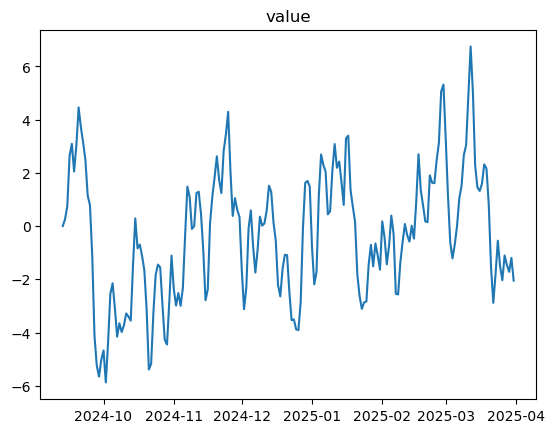

In [5]:
# 数据可视化
import matplotlib.pyplot as plt

plt.plot(data['Value'])
plt.title('value')
plt.show()

### 平稳性

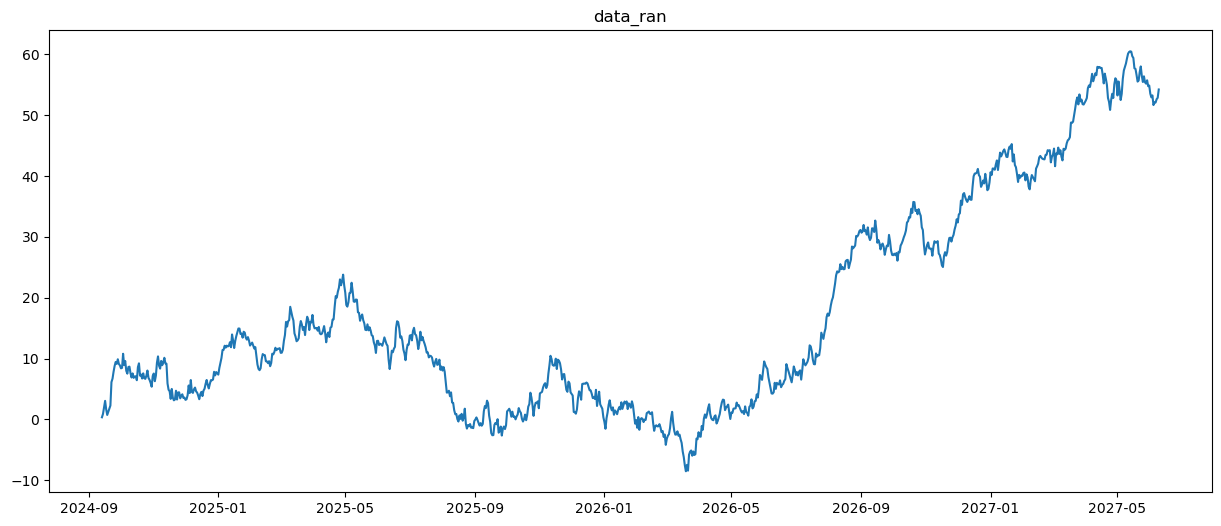

In [6]:
# 构建时间序列

data_ran = pd.DataFrame(
    np.random.randn(1000, 1), # 1000行1列
    index = pd.date_range('2024-09-13', periods=1000), # 行为索引
    columns = ['data'] # 列名
)
data_ran['data'] = data_ran['data'].cumsum()

plt.figure(figsize=(15, 6))
plt.plot(data_ran['data'])
plt.title('data_ran')
plt.show()

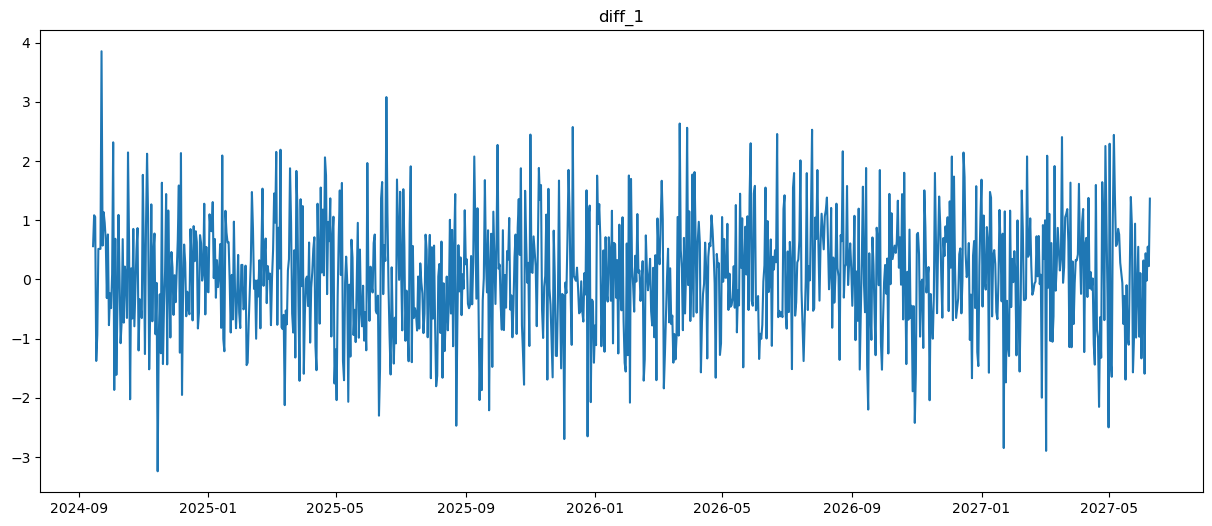

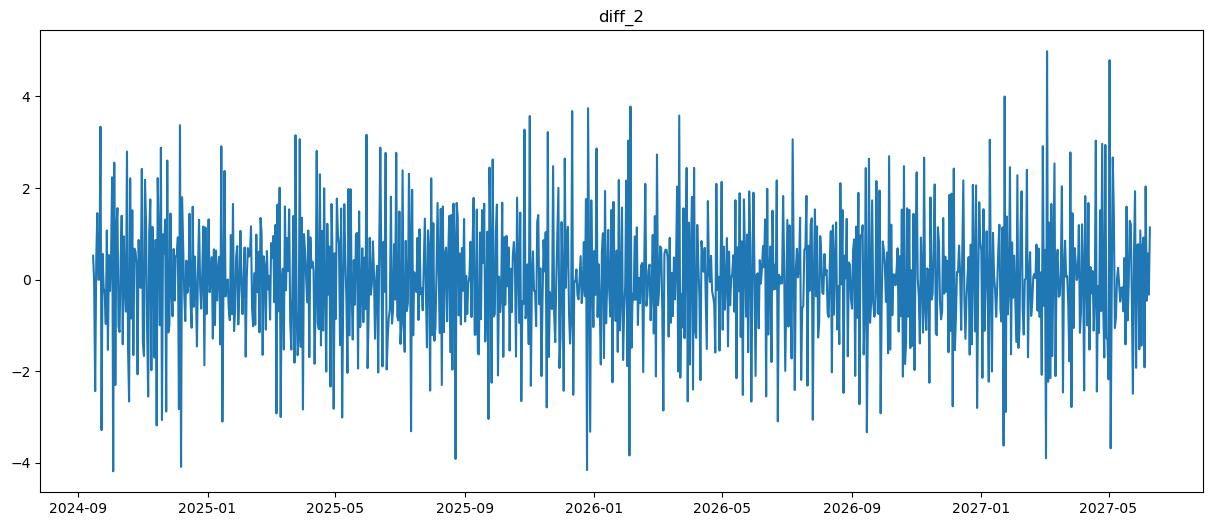

In [7]:
# 平稳性——差分处理

# 一阶差分处理
data_ran['diff_1'] = data_ran['data'].diff(1)
plt.figure(figsize=(15, 6))
plt.plot(data_ran['diff_1'])
plt.title('diff_1')
plt.show()

# 二阶差分处理
data_ran['diff_2'] = data_ran['diff_1'].diff(1)
plt.figure(figsize=(15, 6))
plt.plot(data_ran['diff_2'])
plt.title('diff_2')
plt.show()

可以看到，时间序列在进行一阶差分后就已经接近于平稳序列了

### 模型定阶

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


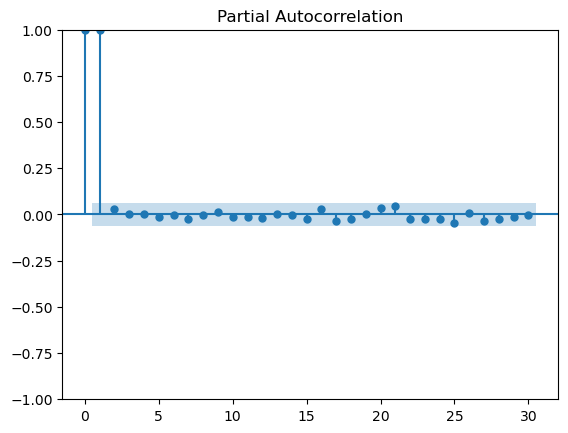

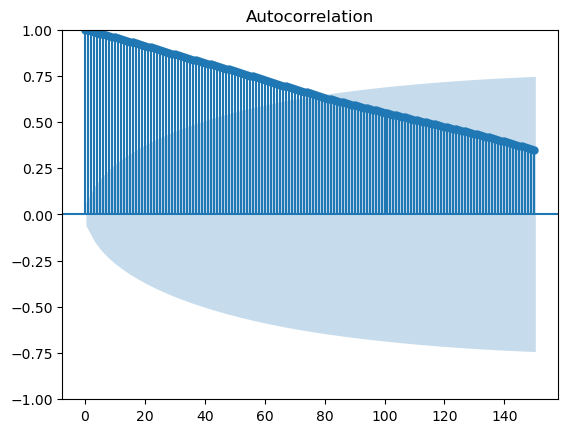

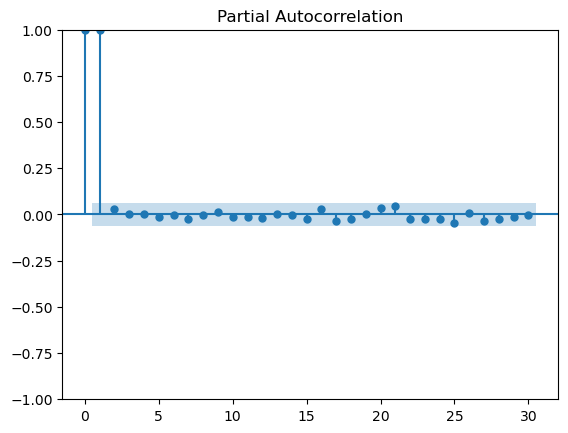

In [8]:
from scipy import stats
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(data_ran['data'], lags=150) # 自相关系数
sm.graphics.tsa.plot_pacf(data_ran['data'], lags=30) # 偏自相关系数

### 平稳时间序列建模

平稳性检验

In [11]:
from statsmodels.tsa.stattools import adfuller as ADF
diff = 0
# 采用单位根检验ADF检验时序是否平稳
def ADF_test(series):
    adf = ADF(series)
    if adf[1] > 0.05:
        print('序列是不平稳的,p为:', adf[1])
    else:
        print('序列是平稳的,p为:', adf[1])
        
ADF_test(data['Value'])

序列是平稳的,p为: 0.021327484537574687


白噪声检验

In [12]:
# 若序列是白噪声序列，说明序列中有用的信息已经提取完毕，只剩随机扰动
# 采用LB统计量进行白噪声检验
def white_noise_test(series):
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb = acorr_ljungbox(series, lags=1)
    p = lb.values[0,1]
    if p<0.05:
        print('序列是非白噪声序列,p为:', p)
    else:
        print('序列是白噪声序列,p为:', p)
        
white_noise_test(data['Value'])

序列是非白噪声序列,p为: 4.730007280799861e-36


In [13]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 定义绘图函数，画出原信号、ACF、PACF图
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 指定轴
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # 绘制图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series Analysis Plots')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()
    plt.show()
    return None

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


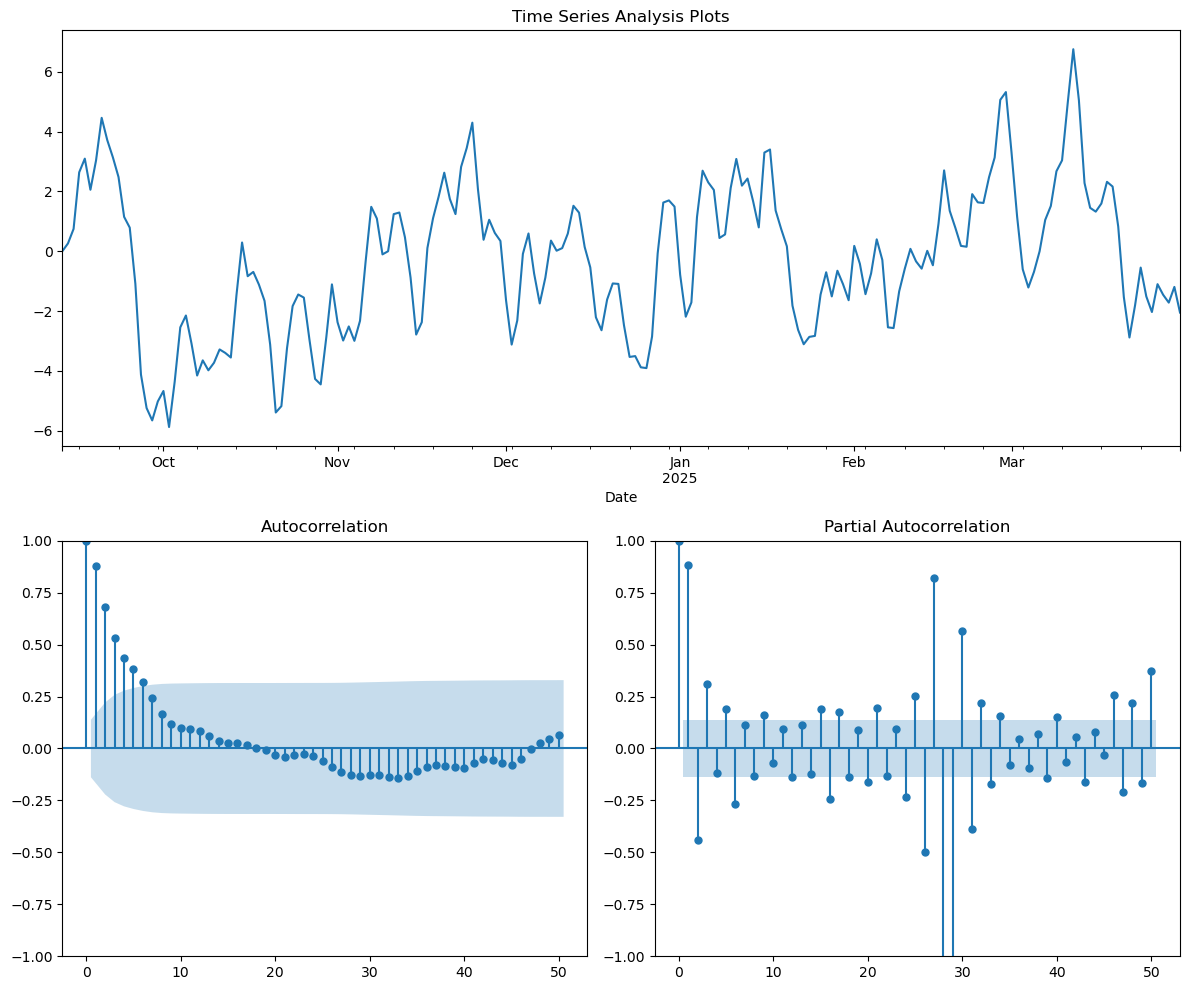

In [15]:
# 画出三图
plotds(data['Value'], nlag=50)

根据ACF、PACF图可以发现均为拖尾的，因此我们采用ARMA模型，并想要进一步确定模型阶数

In [16]:
import statsmodels.tsa.api as smtsa

aicVal = []
for ari in range(0,3):
    for maj in range(0,3):
        try:
            arma_obj = smtsa.ARIMA(data['Value'].tolist(), order=(ari, 0, maj)).fit(method='innovations_mle')
            print(arma_obj.summary())
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)

print(aicVal)
min_aic = min(aicVal, key=lambda x: x[2])

SyntaxError: unexpected EOF while parsing (3326397594.py, line 4)